Extracting archive...


/tmp/ipython-input-817323457.py:32: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()


Done!
Selected audio files:
LibriSpeech/test-clean/5105/28240/5105-28240-0006.flac
LibriSpeech/test-clean/5105/28240/5105-28240-0022.flac


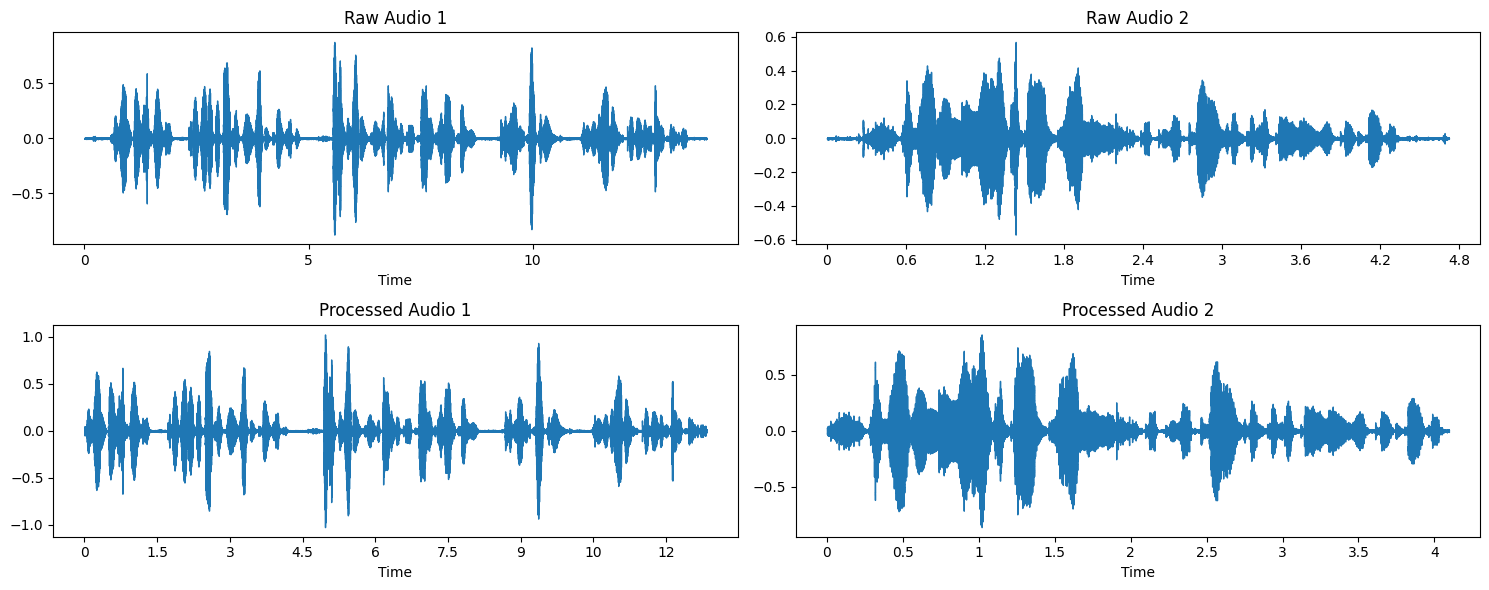

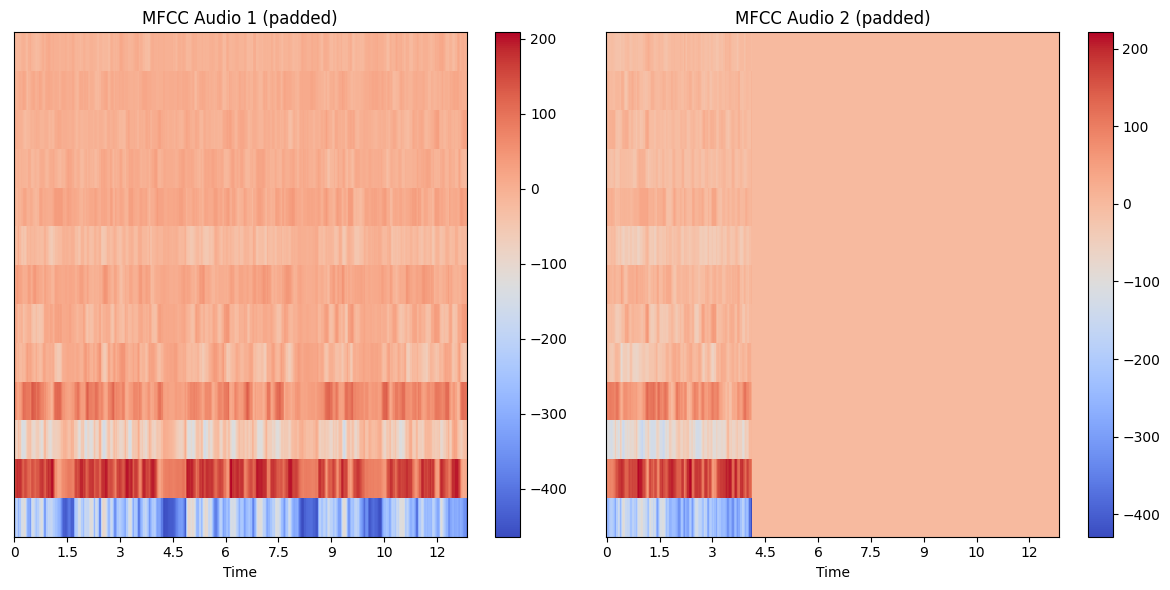

Combined features tensor shape: torch.Size([2, 13, 402])


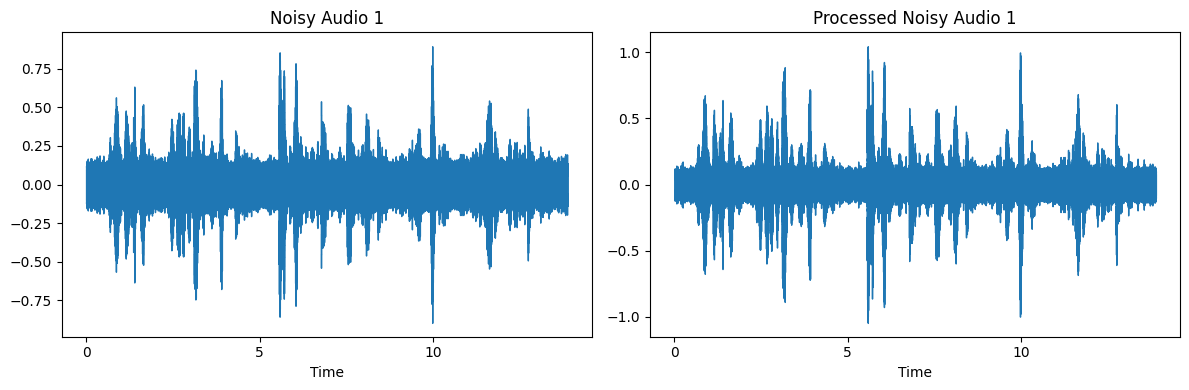

In [4]:
# -----------------------------------
# Download, extract, preprocess, visualize, and extract features
# from two audio samples from LibriSpeech test-clean
# -----------------------------------

# Install required libraries
!pip install librosa matplotlib scipy torch

import os
import tarfile
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
import torch

# -----------------------------------
# Step 1: Download and Extract LibriSpeech test-clean
# -----------------------------------

dataset_url = "http://www.openslr.org/resources/12/test-clean.tar.gz"
archive_name = "test-clean.tar.gz"

# Download the archive
print("Downloading LibriSpeech test-clean (around 330MB)...")
!wget -q $dataset_url

# Extract
print("Extracting archive...")
with tarfile.open(archive_name, "r:gz") as tar:
    tar.extractall()

print("Done!")

# -----------------------------------
# Step 2: Pick Two Audio Samples
# -----------------------------------

# You can list files and choose any two
root_dir = "LibriSpeech/test-clean"

# Find .flac files
audio_files = []
for subdir, dirs, files in os.walk(root_dir):
    for file in files:
        if file.endswith(".flac"):
            audio_files.append(os.path.join(subdir, file))

# Take first two for the assignment
audio_path1 = audio_files[0]
audio_path2 = audio_files[1]

print("Selected audio files:")
print(audio_path1)
print(audio_path2)

# Load the audio
y1, sr1 = librosa.load(audio_path1, sr=None)
y2, sr2 = librosa.load(audio_path2, sr=None)

# -----------------------------------
# Step 3: Preprocessing
# -----------------------------------

TARGET_SR = 16000

def preprocess_audio(y, sr):
    # 1) Resample to 16 kHz
    y_resampled = librosa.resample(y, orig_sr=sr, target_sr=TARGET_SR)
    # 2) Normalize
    y_norm = y_resampled / np.max(np.abs(y_resampled))
    # 3) Silence trimming
    y_trimmed, _ = librosa.effects.trim(y_norm, top_db=20)
    # 4) Optional low-pass filter (4 kHz cutoff)
    sos = scipy.signal.butter(10, 4000, 'low', fs=TARGET_SR, output='sos')
    y_filtered = scipy.signal.sosfilt(sos, y_trimmed)
    return y_filtered

y1_processed = preprocess_audio(y1, sr1)
y2_processed = preprocess_audio(y2, sr2)

# -----------------------------------
# Step 4: Visualize Raw vs Processed
# -----------------------------------

plt.figure(figsize=(15,6))

plt.subplot(2,2,1)
librosa.display.waveshow(y1, sr=sr1)
plt.title("Raw Audio 1")

plt.subplot(2,2,2)
librosa.display.waveshow(y2, sr=sr2)
plt.title("Raw Audio 2")

plt.subplot(2,2,3)
librosa.display.waveshow(y1_processed, sr=TARGET_SR)
plt.title("Processed Audio 1")

plt.subplot(2,2,4)
librosa.display.waveshow(y2_processed, sr=TARGET_SR)
plt.title("Processed Audio 2")

plt.tight_layout()
plt.show()

# -----------------------------------
# Step 5: Extract MFCC Features
# -----------------------------------

def extract_mfcc(y, sr, n_mfcc=13):
    return librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

mfcc1 = extract_mfcc(y1_processed, TARGET_SR)
mfcc2 = extract_mfcc(y2_processed, TARGET_SR)

# -----------------------------------
# Step 5a: Pad MFCCs to Same Shape
# -----------------------------------

max_frames = max(mfcc1.shape[1], mfcc2.shape[1])

def pad_mfcc(mfcc, max_frames):
    pad_width = max_frames - mfcc.shape[1]
    if pad_width > 0:
        mfcc = np.pad(mfcc, ((0,0),(0,pad_width)), mode='constant')
    return mfcc

mfcc1_padded = pad_mfcc(mfcc1, max_frames)
mfcc2_padded = pad_mfcc(mfcc2, max_frames)

# Plot MFCCs
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
librosa.display.specshow(mfcc1_padded, x_axis='time', sr=TARGET_SR)
plt.colorbar()
plt.title("MFCC Audio 1 (padded)")

plt.subplot(1,2,2)
librosa.display.specshow(mfcc2_padded, x_axis='time', sr=TARGET_SR)
plt.colorbar()
plt.title("MFCC Audio 2 (padded)")

plt.tight_layout()
plt.show()

# -----------------------------------
# Step 6: Combine into Tensor
# -----------------------------------

features_tensor = torch.tensor(np.stack([mfcc1_padded, mfcc2_padded]), dtype=torch.float32)
print("Combined features tensor shape:", features_tensor.shape)

# -----------------------------------
# Step 7: Bonus — Noise Addition
# -----------------------------------

def add_noise(y, noise_level=0.02):
    noise = np.random.randn(len(y))
    return y + noise_level * noise

y1_noisy = preprocess_audio(add_noise(y1, 0.05), sr1)
y2_noisy = preprocess_audio(add_noise(y2, 0.05), sr2)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
librosa.display.waveshow(add_noise(y1, 0.05), sr=sr1)
plt.title("Noisy Audio 1")

plt.subplot(1,2,2)
librosa.display.waveshow(y1_noisy, sr=TARGET_SR)
plt.title("Processed Noisy Audio 1")

plt.tight_layout()
plt.show()
